<a href="https://colab.research.google.com/github/sameer203/Tensorflow_/blob/main/12_skimlit_nlp_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Get the Data

In [2]:
!nvidia-smi

Sun Nov  7 10:53:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
# Check what files are in the PubMed_20K dataset 
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [5]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
import os
filenames= [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

### preprocess Data

In [7]:
# Function to preprocess data

def get_lines(filename):
  with open(filename,"r") as f:
    return f.readlines()

In [8]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [9]:
len(train_lines)

210040

In [10]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] =  len(abstract_line_split) -1 
        abstract_samples.append(line_data)
    else:
      abstract_lines += line
  return abstract_samples

In [11]:
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

In [12]:
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [13]:
train_samples[:5]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [14]:
import pandas as pd

In [15]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [16]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [17]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

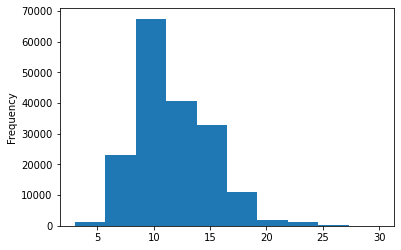

In [18]:
train_df.total_lines.plot.hist()

### get lists of sentences

In [19]:
train_sentences= train_df["text"].tolist()
val_sentences= val_df["text"].tolist()
test_sentences= test_df["text"].tolist()

In [20]:
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [21]:
train_sentences[1]

'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .'

### Make numeric Labels

In [22]:
# one hot Encoding of labels

from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [23]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [24]:
import tensorflow as tf 
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Label encode labels

In [25]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [26]:
train_labels_encoded[:50]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 1, 0, 0, 3, 3, 2, 2, 2, 4, 4, 1,
       1, 0, 0, 2, 2, 2, 2, 2, 2, 4, 4, 4, 1, 1, 1, 0, 3, 2, 2, 2, 2, 4,
       4, 4, 4, 4, 1, 1])

In [27]:
num_classes  = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Model 0 : Baseline model

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


In [29]:
# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

In [30]:
# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [31]:
baseline_score = model_0.score(val_sentences, val_labels_encoded)
baseline_score*100

72.1832384482987

In [32]:
baseline_pred = model_0.predict(val_sentences)
baseline_pred

array([4, 1, 3, ..., 4, 4, 1])

### Getting Helper Function

In [33]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-11-07 10:54:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-07 10:54:18 (88.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [34]:
from helper_functions import calculate_results

In [35]:
baseline_results = calculate_results(val_labels_encoded,
                                     baseline_pred)

In [36]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

### Preparing the data for Deep Sequencing models

In [37]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [38]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]

In [39]:
sent_lens[:5]

[49, 27, 15, 14, 35]

In [40]:
avg_sent_len = np.mean(sent_lens)
round(avg_sent_len)

26

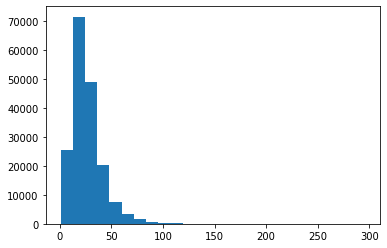

In [41]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=25);

In [42]:
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

### Text Vectorizer Layer

In [43]:
max_tokens = 68000

In [44]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [45]:
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=55)

In [46]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [47]:
!nvidia-smi

Sun Nov  7 10:54:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    33W / 250W |    361MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [48]:
import random
target_sentence = random.choice(train_sentences)
target_sentence, len(target_sentence), text_vectorizer([target_sentence])

('fibrocaps had good safety and efficacy profiles , supporting continuing clinical development as a novel fibrin sealant .',
 120,
 <tf.Tensor: shape=(1, 55), dtype=int64, numpy=
 array([[12120,    55,   745,   136,     3,    79,  1112,  2556,  2899,
            47,   501,    25,     8,   741,  5842,  5406,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0]])>)

In [49]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
len(rct_20k_text_vocab), rct_20k_text_vocab[:5], rct_20k_text_vocab[-5:]

(64841,
 ['', '[UNK]', 'the', 'and', 'of'],
 ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp'])

In [50]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

### Creating a Embedding Layer

In [51]:
# token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="Token_embedding")

In [52]:
target_sentence, text_vectorizer([target_sentence]), token_embed(text_vectorizer([target_sentence]))

('fibrocaps had good safety and efficacy profiles , supporting continuing clinical development as a novel fibrin sealant .',
 <tf.Tensor: shape=(1, 55), dtype=int64, numpy=
 array([[12120,    55,   745,   136,     3,    79,  1112,  2556,  2899,
            47,   501,    25,     8,   741,  5842,  5406,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0]])>,
 <tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
 array([[[-0.0243107 ,  0.02217415,  0.04966738, ..., -0.04652546,
           0.03945969,  0.02975823],
         [-0.0479051 ,  0.04932144, -0.0221573 , ..., -0.01269459,
           0.01940049,  0.03266251],
         [ 0.02589018,  0.00359125, -0.03456212, ...,  0.04575295,
          -0.02528938, -0.01523529],
        

In [53]:
token_embed(text_vectorizer([target_sentence])).shape

TensorShape([1, 55, 128])

### Better performances with tf datasets

In [54]:
train_datasets = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_datasets = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_datasets = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [55]:
train_datasets

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [56]:
train_datasets = train_datasets.batch(32).prefetch(tf.data.AUTOTUNE)
valid_datasets = valid_datasets.batch(32).prefetch(tf.data.AUTOTUNE)
test_datasets = test_datasets.batch(32).prefetch(tf.data.AUTOTUNE)

In [57]:
train_datasets

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

### Model 1: Conv1D

In [58]:
# Model 1
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_Conv1d")

In [59]:
model_1.summary()

Model: "model_1_Conv1d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
Token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 51, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
__________________________________________

In [60]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1_history = model_1.fit(train_datasets,
            epochs=5,
            steps_per_epoch = int(0.1 * len(train_datasets)),
            validation_data=valid_datasets,
            validation_steps = int(0.1 * len(valid_datasets)))

Epoch 1/5
562/562 [==============================] - 19s 6ms/step - loss: 0.9354 - accuracy: 0.6288 - val_loss: 0.7182 - val_accuracy: 0.7274
Epoch 2/5
562/562 [==============================] - 3s 6ms/step - loss: 0.6846 - accuracy: 0.7459 - val_loss: 0.6611 - val_accuracy: 0.7596
Epoch 3/5
562/562 [==============================] - 3s 6ms/step - loss: 0.6394 - accuracy: 0.7648 - val_loss: 0.6179 - val_accuracy: 0.7759
Epoch 4/5
562/562 [==============================] - 3s 6ms/step - loss: 0.6081 - accuracy: 0.7813 - val_loss: 0.5987 - val_accuracy: 0.7816
Epoch 5/5
562/562 [==============================] - 3s 6ms/step - loss: 0.6034 - accuracy: 0.7865 - val_loss: 0.5762 - val_accuracy: 0.7942


In [61]:
model_1.evaluate(valid_datasets)

945/945 [==============================] - 3s 3ms/step - loss: 0.5755 - accuracy: 0.7953


[0.575495183467865, 0.7952800393104553]

In [62]:
model_1_pred_probs = model_1.predict(valid_datasets)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 79.52800211836356,
 'f1': 0.792006158905271,
 'precision': 0.7948782881031071,
 'recall': 0.7952800211836356}

In [63]:
# Model 1
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_Conv1d")

In [64]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [65]:
model_1_1_history = model_1.fit(train_datasets,
            epochs=5,
            validation_data=valid_datasets,
            )

Epoch 1/5
5627/5627 [==============================] - 33s 6ms/step - loss: 0.5063 - accuracy: 0.8153 - val_loss: 0.4965 - val_accuracy: 0.8176
Epoch 2/5
5627/5627 [==============================] - 32s 6ms/step - loss: 0.3722 - accuracy: 0.8693 - val_loss: 0.5199 - val_accuracy: 0.8132
Epoch 3/5
5627/5627 [==============================] - 32s 6ms/step - loss: 0.2387 - accuracy: 0.9228 - val_loss: 0.6025 - val_accuracy: 0.8037
Epoch 4/5
5627/5627 [==============================] - 32s 6ms/step - loss: 0.1334 - accuracy: 0.9608 - val_loss: 0.7556 - val_accuracy: 0.7902
Epoch 5/5
5627/5627 [==============================] - 32s 6ms/step - loss: 0.0715 - accuracy: 0.9806 - val_loss: 0.9258 - val_accuracy: 0.7826


In [66]:
model_1.evaluate(valid_datasets)

945/945 [==============================] - 3s 3ms/step - loss: 0.9258 - accuracy: 0.7826


[0.9258094429969788, 0.7826360464096069]

In [67]:
model_1_pred_probs = model_1.predict(valid_datasets)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.26360386601351,
 'f1': 0.7802645528606253,
 'precision': 0.7810709632615006,
 'recall': 0.7826360386601351}

### Model 2: Feature Extraction with pretrained token embeddings

In [68]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [69]:
# Model 2
model_2 = tf.keras.Sequential([
                               tf_hub_embedding_layer,
                               layers.Dense(128, activation="relu"),
                               layers.Dense(5, activation="softmax")
])

model_2.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer =tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [70]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [71]:
model_2.fit(train_datasets,
            steps_per_epoch=int(0.1 * len(train_datasets)),
            epochs=3,
            validation_data=valid_datasets,
            validation_steps=int(0.1 * len(valid_datasets)))

Epoch 1/3
562/562 [==============================] - 9s 12ms/step - loss: 0.9133 - accuracy: 0.6519 - val_loss: 0.7960 - val_accuracy: 0.6905
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7676 - accuracy: 0.7015 - val_loss: 0.7550 - val_accuracy: 0.7061
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7516 - accuracy: 0.7124 - val_loss: 0.7401 - val_accuracy: 0.7088


In [72]:
model_2.evaluate(valid_datasets)

945/945 [==============================] - 9s 9ms/step - loss: 0.7411 - accuracy: 0.7131


[0.7411022782325745, 0.7130941152572632]

In [73]:
model_2_pred_probs = model_2.predict(valid_datasets)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.30941347808817,
 'f1': 0.7102405379957484,
 'precision': 0.7136847876832715,
 'recall': 0.7130941347808818}

In [74]:
# Making trainable=True
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True,
                                        name="universal_sentence_encoder")

In [75]:
# Model 2_1
model_2_1 = tf.keras.Sequential([
                               tf_hub_embedding_layer,
                               layers.Dense(128, activation="relu"),
                               layers.Dense(5, activation="softmax")
])

model_2_1.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer =tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [76]:
model_2_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 256,864,133
Non-trainable params: 0
_________________________________________________________________


In [77]:
model_2_1.fit(train_datasets,
            steps_per_epoch=int(0.1 * len(train_datasets)),
            epochs=5,
            validation_data=valid_datasets,
            validation_steps=int(0.1 * len(valid_datasets)))

Epoch 1/5
562/562 [==============================] - 51s 83ms/step - loss: 0.7489 - accuracy: 0.7085 - val_loss: 0.5529 - val_accuracy: 0.7896
Epoch 2/5
562/562 [==============================] - 46s 82ms/step - loss: 0.5563 - accuracy: 0.7949 - val_loss: 0.5312 - val_accuracy: 0.7889
Epoch 3/5
562/562 [==============================] - 46s 82ms/step - loss: 0.5264 - accuracy: 0.8018 - val_loss: 0.4981 - val_accuracy: 0.8072
Epoch 4/5
562/562 [==============================] - 47s 83ms/step - loss: 0.5001 - accuracy: 0.8165 - val_loss: 0.4779 - val_accuracy: 0.8172
Epoch 5/5
562/562 [==============================] - 47s 83ms/step - loss: 0.5025 - accuracy: 0.8173 - val_loss: 0.4784 - val_accuracy: 0.8205


In [78]:
model_2_1.evaluate(valid_datasets)

945/945 [==============================] - 9s 10ms/step - loss: 0.4832 - accuracy: 0.8168


[0.4832494854927063, 0.8167946338653564]

In [79]:
model_2_1_pred_probs = model_2_1.predict(valid_datasets)
model_2_1_preds = tf.argmax(model_2_1_pred_probs, axis=1)
model_2_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_1_preds)
model_2_1_results

{'accuracy': 81.67946511320005,
 'f1': 0.8186147552984822,
 'precision': 0.8303929591329579,
 'recall': 0.8167946511320006}

### Model 3: Conv1D with character embeddings

In [80]:
# Function to split sentences to characters
def split_chars(text):
  return " ".join(list(text))

In [81]:
split_chars(target_sentence)

'f i b r o c a p s   h a d   g o o d   s a f e t y   a n d   e f f i c a c y   p r o f i l e s   ,   s u p p o r t i n g   c o n t i n u i n g   c l i n i c a l   d e v e l o p m e n t   a s   a   n o v e l   f i b r i n   s e a l a n t   .'

In [82]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [83]:
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [84]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

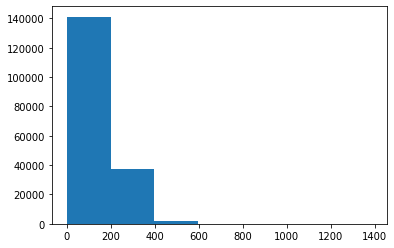

In [85]:
plt.hist(char_lens, bins=7);

In [86]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [87]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

In [88]:
len(alphabet), alphabet

(68, 'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')

In [89]:
NUM_CHAR_TOKENS = len(alphabet) + 2

char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [90]:
char_vectorizer.adapt(train_chars)

In [91]:
char_vocab = char_vectorizer.get_vocabulary()
char_vocab, len(char_vocab)

(['',
  '[UNK]',
  'e',
  't',
  'i',
  'a',
  'n',
  'o',
  'r',
  's',
  'd',
  'c',
  'l',
  'h',
  'p',
  'm',
  'u',
  'f',
  'g',
  'y',
  'w',
  'v',
  'b',
  'k',
  'x',
  'z',
  'q',
  'j'],
 28)

In [92]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
i n   t h e   s t o n e   m i g r a t i o n   s u b s e t t i n g   ,   l e s s   s t o n e s   f r a g m e n t s   w e r e   f o u n d   t o   m i g r a t e   i n t o   l o w e r   c a l i c e s   i n   t u r s l   s t o n e   m i g r a t i o n   s u b g r o u p   (   p   =   @   )   .

Length of chars: 118

Vectorized chars:
[[ 4  6  3 13  2  9  3  7  6  2 15  4 18  8  5  3  4  7  6  9 16 22  9  2
   3  3  4  6 18 12  2  9  9  9  3  7  6  2  9 17  8  5 18 15  2  6  3  9
  20  2  8  2 17  7 16  6 10  3  7 15  4 18  8  5  3  2  4  6  3  7 12  7
  20  2  8 11  5 12  4 11  2  9  4  6  3 16  8  9 12  9  3  7  6  2 15  4
  18  8  5  3  4  7  6  9 16 22 18  8  7 16 14 14  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [93]:
# token embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                               output_dim=25,
                               mask_zero=True,
                               name="Char_embedding")

In [94]:
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
i n   t h e   s t o n e   m i g r a t i o n   s u b s e t t i n g   ,   l e s s   s t o n e s   f r a g m e n t s   w e r e   f o u n d   t o   m i g r a t e   i n t o   l o w e r   c a l i c e s   i n   t u r s l   s t o n e   m i g r a t i o n   s u b g r o u p   (   p   =   @   )   .

Embedded chars (after vectorization and embedding):
[[[-0.01363354 -0.01540475 -0.03604921 ... -0.01240528 -0.00439514
    0.04246447]
  [-0.01601505  0.01708591 -0.0263544  ...  0.02967091 -0.04526682
   -0.03570114]
  [ 0.03464193 -0.04400629 -0.03252297 ...  0.01207192  0.03230263
    0.02477093]
  ...
  [ 0.03590638  0.03593162 -0.00081605 ...  0.03557471 -0.00872288
   -0.04836467]
  [ 0.03590638  0.03593162 -0.00081605 ...  0.03557471 -0.00872288
   -0.04836467]
  [ 0.03590638  0.03593162 -0.00081605 ...  0.03557471 -0.00872288
   -0.04836467]]]

Character embedding shape: (1, 290, 25)


In [95]:
# Model 3
inputs = layers.Input(shape=(1,), dtype="string")
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="same")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv_1d")

In [96]:
model_3.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [97]:
model_3.summary()

Model: "model_3_conv_1d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
Char_embedding (Embedding)   (None, 290, 25)           700       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________

In [98]:
train_char_datasets = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_datasets = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_datasets = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


In [99]:
val_chars[0]

'i g e   s e n s i t i z a t i o n   t o   a s p e r g i l l u s   f u m i g a t u s   a n d   a   p o s i t i v e   s p u t u m   f u n g a l   c u l t u r e   r e s u l t   a r e   c o m m o n   i n   p a t i e n t s   w i t h   r e f r a c t o r y   a s t h m a   .'

In [100]:
model_3_history = model_3.fit(train_char_datasets,
                              steps_per_epoch=int(0.1*len(train_char_datasets)),
                              epochs=5,
                              validation_data=val_char_datasets,
                              validation_steps=int(0.1*len(val_char_datasets)))

Epoch 1/5
562/562 [==============================] - 4s 5ms/step - loss: 1.2869 - accuracy: 0.4919 - val_loss: 1.0579 - val_accuracy: 0.5914
Epoch 2/5
562/562 [==============================] - 3s 5ms/step - loss: 1.0127 - accuracy: 0.5948 - val_loss: 0.9422 - val_accuracy: 0.6326
Epoch 3/5
562/562 [==============================] - 3s 5ms/step - loss: 0.9295 - accuracy: 0.6364 - val_loss: 0.8774 - val_accuracy: 0.6586
Epoch 4/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8791 - accuracy: 0.6579 - val_loss: 0.8497 - val_accuracy: 0.6642
Epoch 5/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8634 - accuracy: 0.6650 - val_loss: 0.8244 - val_accuracy: 0.6825


In [101]:
model_3.evaluate(val_char_datasets)

945/945 [==============================] - 3s 3ms/step - loss: 0.8350 - accuracy: 0.6787


[0.8349589705467224, 0.6787369251251221]

In [102]:
model_3_pred_probs = model_3.predict(val_char_datasets)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 67.87369257248776,
 'f1': 0.6730208716905279,
 'precision': 0.679947823715569,
 'recall': 0.6787369257248775}

### Model 4: Combining pretrained token embeddings and characters embeddings

In [103]:
# Model 4

#1. Setup token inputs/Model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_output)

#2. Setup Char inputs/models
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

#3. concatenate token and char inputs
token_char_concat = layers.Concatenate(name="token_char_concate")([token_model.output,
                                                                   char_model.output])

#4. Create outputs layers- adding in droupouts
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation="softmax")(final_dropout)

#5.model with token and char inputs
model_4 = tf.keras.Model(inputs=[token_model.inputs, char_model.input],
                         outputs = output_layer,
                         name="model_4_token_and_char_embeddings")



In [104]:
# compile the model
model_4.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [105]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

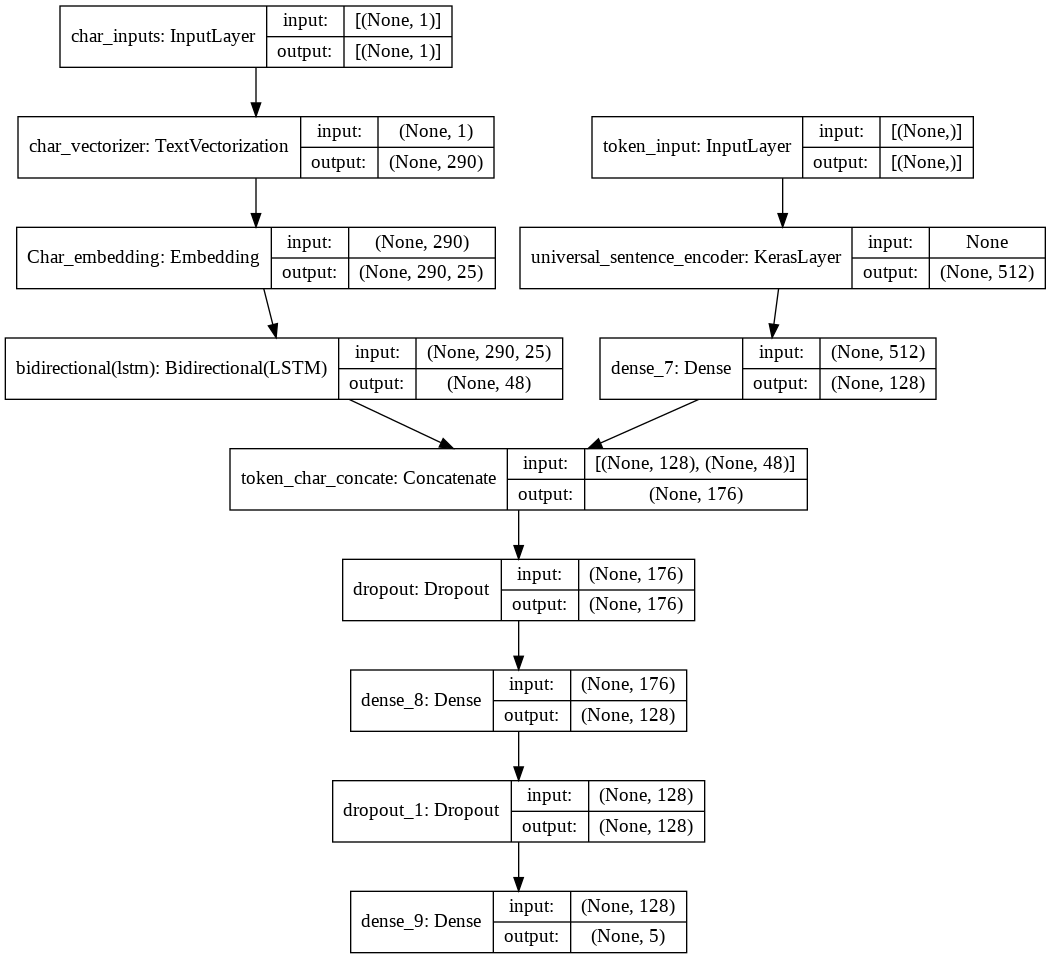

In [106]:
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [107]:
# Combine chars and tokens into single inputs
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# For validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [108]:
# Fit the model
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=5,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/5
562/562 [==============================] - 75s 116ms/step - loss: 0.4293 - accuracy: 0.8602 - val_loss: 0.5609 - val_accuracy: 0.8241
Epoch 2/5
562/562 [==============================] - 63s 112ms/step - loss: 0.2626 - accuracy: 0.9209 - val_loss: 0.5562 - val_accuracy: 0.8122
Epoch 3/5
562/562 [==============================] - 61s 109ms/step - loss: 0.2434 - accuracy: 0.9249 - val_loss: 0.6584 - val_accuracy: 0.7892
Epoch 4/5
562/562 [==============================] - 64s 114ms/step - loss: 0.2220 - accuracy: 0.9332 - val_loss: 0.5886 - val_accuracy: 0.8042
Epoch 5/5
562/562 [==============================] - 62s 111ms/step - loss: 0.2362 - accuracy: 0.9280 - val_loss: 0.6377 - val_accuracy: 0.7939


In [109]:
!nvidia-smi

Sun Nov  7 11:09:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    42W / 250W |   9051MiB / 16280MiB |     19%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [110]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.6565 - accuracy: 0.7894


[0.6564961075782776, 0.7893882989883423]

In [111]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 78.93883225208526,
 'f1': 0.7922417267445189,
 'precision': 0.8044052390379727,
 'recall': 0.7893883225208527}

### Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [112]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [113]:
# Use one-hot-encoding for the "line-number" coloum
train_line_numbers_oht = tf.one_hot(train_df["line_number"].to_numpy(), depth=20)
val_line_numbers_oht = tf.one_hot(val_df["line_number"].to_numpy(), depth=20)
test_line_numbers_oht = tf.one_hot(test_df["line_number"].to_numpy(), depth=20)

train_line_numbers_oht[:10], train_line_numbers_oht.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0

In [114]:
# Total lines
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

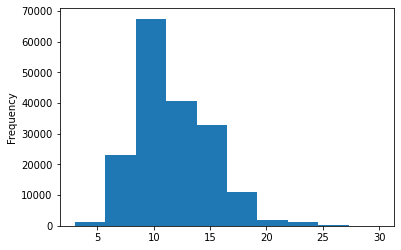

In [115]:
train_df.total_lines.plot.hist()

In [117]:
np.percentile(train_df.total_lines, 98)

20.0

In [116]:
# Use one-hot-encoding for the "total_lines" coloum
train_total_lines_oht = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_oht = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_oht = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_oht[:10], train_total_lines_oht.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

## building a tribrid model

In [123]:
#1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

#2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs,
                            char_bi_lstm)

#3. Line numbers
line_number_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

#4. total lines
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

#5. combine token and char embeddings
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

#Droupout layer
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

#6. Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

#7. output layer
output_layer = layers.Dense(5, activation="relu", name="output_layer")(tribrid_embeddings)

#8. put together all inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [125]:
model_5.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
___________________________________________________________________________________________

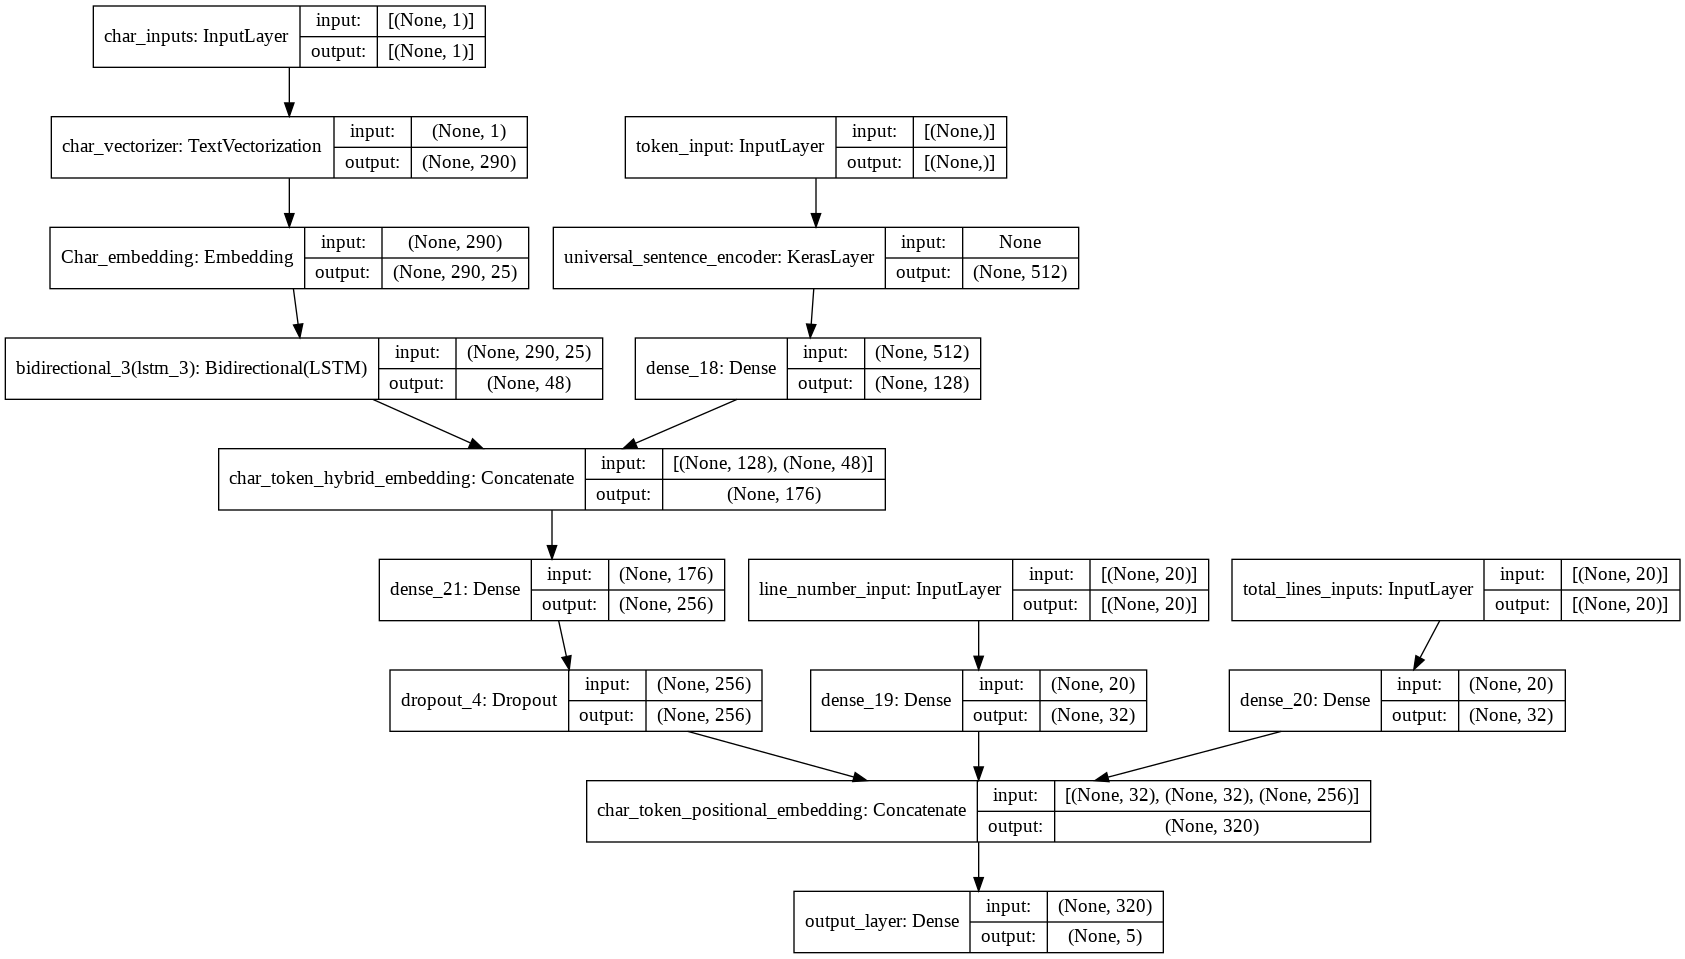

In [127]:
plot_model(model_5,show_shapes=True)

In [130]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [132]:
# Create training and validation datasets
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_oht,
                                                                train_total_lines_oht,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))

train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))

train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#Validation data
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_oht,
                                                                val_total_lines_oht,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))

val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))

val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [134]:
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset shapes: (((None, 20), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 20), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [136]:
model_5_history = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                              epochs=5,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/5
562/562 [==============================] - 75s 115ms/step - loss: nan - accuracy: 0.9273 - val_loss: 0.9818 - val_accuracy: 0.8059
Epoch 2/5
562/562 [==============================] - 63s 112ms/step - loss: 0.7821 - accuracy: 0.9730 - val_loss: 0.9727 - val_accuracy: 0.8025
Epoch 3/5
562/562 [==============================] - 60s 108ms/step - loss: 0.7203 - accuracy: 0.9804 - val_loss: 1.0032 - val_accuracy: 0.7922
Epoch 4/5
562/562 [==============================] - 64s 113ms/step - loss: 0.7130 - accuracy: 0.9769 - val_loss: 0.9977 - val_accuracy: 0.8042
Epoch 5/5
562/562 [==============================] - 61s 109ms/step - loss: 0.7112 - accuracy: 0.9757 - val_loss: 1.0077 - val_accuracy: 0.7995


In [137]:
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 1.0197 - accuracy: 0.7948


[1.0196901559829712, 0.7948166131973267]

In [138]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 79.48166291539785,
 'f1': 0.7957630346766138,
 'precision': 0.7990915726057606,
 'recall': 0.7948166291539785}